# Evaluate model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Setup

### Import packages

In [2]:
from fastai.vision import *

import IPython.display as ipd
from tqdm import tqdm_notebook

### Instantiate ImageDataBunch

In [3]:
pat = r'/(\w+)_\d+.jpg'

In [4]:
path_img = "../mfc_dataset"
fnames = sorted(get_image_files(path_img))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]

[PosixPath('../mfc_dataset/female_3075.jpg'),
 PosixPath('../mfc_dataset/male_3161.jpg'),
 PosixPath('../mfc_dataset/male_4055.jpg'),
 PosixPath('../mfc_dataset/male_5550.jpg'),
 PosixPath('../mfc_dataset/female_3396.jpg')]

In [5]:
data = ImageDataBunch.from_name_re(
    path_img, fnames, pat, size=224, bs=64, valid_pct=0.2, seed=42
).normalize(imagenet_stats)

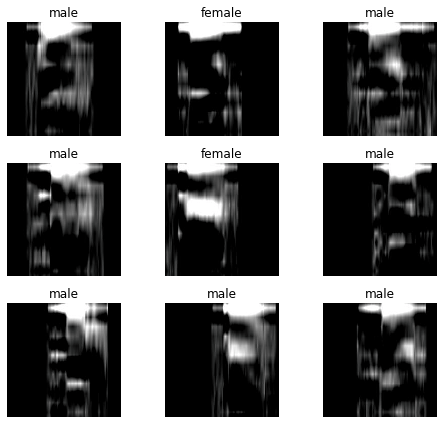

In [6]:
data.show_batch(rows=3, figsize=(7,6))

## Analyze mistakes

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model = load_learner(path_img).model
# ClassificationInterpretation.from_learner requires the learn to has validation data.
# However, load_learner(path_img) does not have validation data.
# Therefore, I had to use the workaround above.

In [8]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

In [9]:
losses, idxs = interp.top_losses()  # only uses data from the validation set

<div style="text-align: justify">
The outliers displayed as MFCs and the Grad-CAM heatmaps are not intuitive because we humans can't read off sounds from MFCs:
</div>

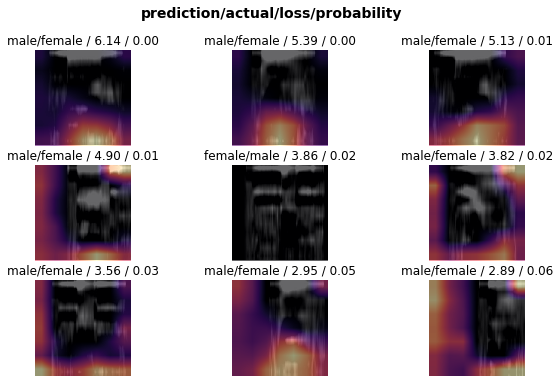

In [10]:
interp.plot_top_losses(9, figsize=(10, 6), heatmap=True)

Instead, let's try hearing the top losses.

In [11]:
def load_json(json_fpath):
    with open(json_fpath, 'r') as json_f:
        return json.load(json_f)

In [12]:
male_idxs_to_wav_fpaths   = load_json('../maps/male_idxs_to_wav_fpaths.json')
female_idxs_to_wav_fpaths = load_json('../maps/female_idxs_to_wav_fpaths.json')

In [13]:
# reference: https://forums.fast.ai/t/how-to-get-data-val-ds-fnames-in-fastai-v1-0/37231
for mfc_path in data.valid_ds.x.items[idxs][:5]:
    mfc_path = str(mfc_path)
    print(mfc_path, end='|')
    wav_fpath = female_idxs_to_wav_fpaths[mfc_path] if 'female' in mfc_path else male_idxs_to_wav_fpaths[mfc_path]
    print(wav_fpath)
    ipd.display(ipd.Audio(wav_fpath))

../mfc_dataset/female_4800.jpg|../../AudioMNIST/data/59/5_59_35.wav


../mfc_dataset/female_1638.jpg|../../AudioMNIST/data/59/1_59_8.wav


../mfc_dataset/female_1035.jpg|../../AudioMNIST/data/59/5_59_44.wav


../mfc_dataset/female_2622.jpg|../../AudioMNIST/data/56/8_56_7.wav


../mfc_dataset/male_14291.jpg|../../AudioMNIST/data/25/6_25_31.wav


### Confusion matrix

The confusion matrix and the F1 score are commonly used to evaluate classifiers:

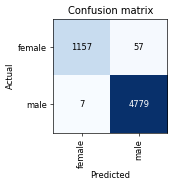

In [14]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

### F1 score

Since this is a binary classification task, we can think of "female" as "true" and "male as "false".

In [15]:
cmat = interp.confusion_matrix()
precision = cmat[0][0] / (cmat[0][0] + cmat[1][0])  # true positives / (true positives + false positives = positive predictions) 
recall = cmat[0][0] / (cmat[0][0] + cmat[0][1])  # true positives / (true positives + false negatives = positive ground truths)
f1_score = 2 / (1 / precision + 1 / recall)

This classifier has a super high F1 score. 

In [16]:
f1_score

0.9730866274179985

## Where is the model looking?

This is an example of how to use fastai's GradCAM functionality:
- idx: the index of the image to use for GradCAM (the image is obtained by indexing into interp.ds)
- image: whether to show GradCAM result on top of the image

In [17]:
cam = interp.GradCAM(idx=3, image=False)

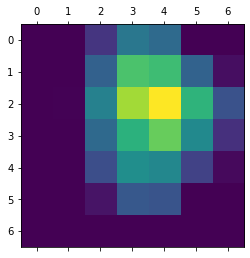

In [18]:
plt.matshow(cam, interpolation=None)
plt.show()

One can make the GradCAM result look better using interpolation:

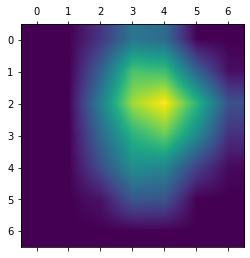

In [19]:
plt.matshow(cam, interpolation='bilinear')
plt.show()

We can compute a mean GradCAM result for each category.

0 represents "female" and 1 represents "male".

In [20]:
data.c2i

{'female': 0, 'male': 1}

In [21]:
binary_labels = []
for cat in interp.ds.y:  # use data.valid_ds.y.get(index) for individual labels
    binary_labels.append(cat.data)

Computing GradCAMs is a slow computation; I've already saved all the GradCAMs inside two JSONs, one for each class / gender.

In [22]:
male_cam_json_fpath = '../results/male_cams.json'
female_cam_json_fpath = '../results/female_cams.json'

In [23]:
if not (os.path.isfile(male_cam_json_fpath) and os.path.isfile(female_cam_json_fpath)):
    recompute_cam = True
else:
    recompute_cam = False

In [24]:
if recompute_cam:
    
    male_cams, female_cams = [], []
    for i, label in tqdm_notebook(enumerate(binary_labels), total=len(interp.ds)):
        
        cam = interp.GradCAM(idx=i, image=False)
        
        if label == 0:  # female
            female_cams.append(cam)
        elif label == 1:  # male
            male_cams.append(cam)
    
    male_cams = np.array([cam.numpy() for cam in male_cams])
    female_cams = np.array([cam.numpy() for cam in female_cams])

In [25]:
if recompute_cam:
    with open(male_cam_json_fpath, 'w+') as json_f:
        json.dump(male_cams.tolist(), json_f) 
else:
    print(f'Loading {male_cam_json_fpath}!')
    male_cams = np.array(load_json(male_cam_json_fpath))

Loading ../results/male_cams.json!


In [26]:
if recompute_cam:
    with open('../results/female_cams.json', 'w+') as json_f:
        json.dump(female_cams.tolist(), json_f) 
else:
    print(f'Loading {female_cam_json_fpath}!')
    female_cams = np.array(load_json(female_cam_json_fpath))

Loading ../results/female_cams.json!


<div style="text-align: justify">
Now the GradCAM results are computed / loaded for each class. The mean GradCAM result (across the batch axis) for each class can then be computed.
</div>

In [27]:
male_cam_summary = np.mean(male_cams, axis=0)
male_cam_summary /= male_cam_summary.max()

In [28]:
female_cam_summary = np.mean(female_cams, axis=0)
female_cam_summary /= female_cam_summary.max()

<div style="text-align: justify">
Visualize the mean GradCAM result for each class. I've reshaped the GradCAMs to the shape of the MFCs. It seems to me that, for female, the model's attention cloud is slightly higher up in terms of frequency bin. Let's verify this observation by taking the mean (of the mean GradCAM result) across the Frame / Window axis for each class.
</div>

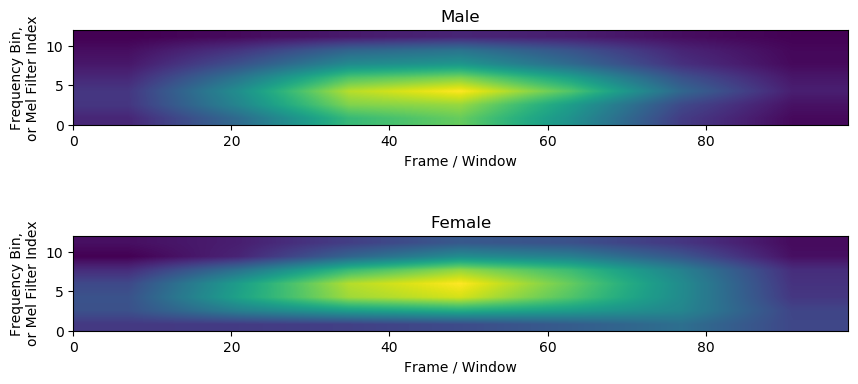

In [29]:
fig = plt.figure(figsize=(10, 5), dpi=100)

ax = fig.add_subplot(211)
ax.imshow(male_cam_summary, extent=(0, 98, 12, 0), interpolation='bilinear')
plt.gca().invert_yaxis()
plt.title('Male')
plt.xlabel('Frame / Window'); plt.ylabel('Frequency Bin,\nor Mel Filter Index')

ax = fig.add_subplot(212)
ax.imshow(female_cam_summary, extent=(0, 98, 12, 0), interpolation='bilinear')
plt.gca().invert_yaxis()
plt.title('Female')
plt.xlabel('Frame / Window'); plt.ylabel('Frequency Bin,\nor Mel Filter Index')

# plt.savefig('../pngs/mean_grad_cams_for_each_class.png', dpi=300)
plt.show()

<div style="text-align: justify">
Note that the two plots above are generated using interpolation. GradCAMs have very poor resolution and can't assign an attention value to each of the 12 frequency bins / Mel filter indices. In fact, each GradCAM is only of dimension 7-by-7. This means that the frequency spectrum is re-quantized into 7 frequency bins instead of 12. Nevertheless, the idea is still valid: as we can see from the horizontal bar-plot below, the model does look more at higher frequencies for female examples. This observation aligns with our intuition that female voices are of higher pitch.
</div>

In [30]:
male_cam_freqwise_mean = male_cam_summary.mean(axis=1)
male_cam_freqwise_mean /= male_cam_freqwise_mean.max()

In [31]:
female_cam_freqwise_mean = female_cam_summary.mean(axis=1)
female_cam_freqwise_mean /= female_cam_freqwise_mean.max()

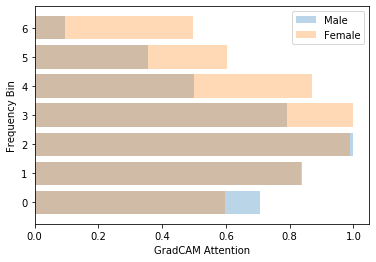

In [32]:
plt.barh(np.arange(len(male_cam_freqwise_mean)), male_cam_freqwise_mean, alpha=0.3, label='Male')
plt.barh(np.arange(len(female_cam_freqwise_mean)), female_cam_freqwise_mean, alpha=0.3, label='Female')
plt.xlabel('GradCAM Attention')
plt.ylabel('Frequency Bin')
plt.legend()
# plt.savefig('../pngs/attention_over_freq_for_each_class.png', dpi=300)
plt.show()